# Artificial Intelligence for Handwriting Recognition

Speakers: Riccardo Finotello, Veronica Guidetti

Code: [Riccardo Finotello](mailto:riccardo.finotello@cea.fr)

[**XVII Avogadro Meeting**](https://www.ggi.infn.it/showevent.pl?id=407), 12/2021, Galileo Galilei Institute for Theoretical Physics, Florence, Italy

# Synopsis

In this small demo, we introduce some technical instruments to deploy a simple AI for the recognition of handwritten digits.
The main idea is to showcase the use of convolutional neural networks and autoencoders in a simple realisation, and to show possible generalisations and applications.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The chosen frameworks for the neural networks are [Tensorflow](https://www.tensorflow.org/) and its high-level API [Keras](https://keras.io/).

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, MaxPool2D,
                                     UpSampling2D)
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam

TRAIN_CNN = True  # set to False to load directly the pretrained models
TRAIN_AE = True  # set to False to load directly the pretrained models

np.random.seed(0)
tf.random.set_seed(0)

sns.set_theme(palette='tab10')

# set the memory growth of the GPU for training, if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:

    try:

        for gpu in gpus:

            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:

        sys.stderr.write(str(e))


## Data Preparation

In this demo we shall use the [MNIST database](http://yann.lecun.com/exdb/mnist/) of handwritten digits.
The dataset contains $6 \times 10^4$ images as training set, and $10^4$ images as test set.
The size of the images is $28~\text{px} \times 28~\text{px}$.
Each realisation in the sets is accompanied by a ground truth label identifying the digits represented.

Images are black and white: only one channel is present. Its intensity varies from $0$ (pure black) to $255$ (pure white).

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# normalise to the maximal intensity
M = X_train.max()
X_train = X_train / M
X_test = X_test / M


In this example, we pad the images by adding two black pixels at the borders.
The procedure modifies the images into $32~\text{px} \times 32~\text{px}$, as it is usually easier to work with powers of $2$.

In [4]:
# pad images to get 32 x 32 inputs (convenience)
X_train = tf.pad(X_train, ((0, 0), (2, 2), (2, 2)))
X_test = tf.pad(X_test, ((0, 0), (2, 2), (2, 2)))


As the objective is a **binary classification**, we *one-hot* encode the labels in the training set. That is, we transform the scalar value of each entry as follows:
$$
y_i \in \{ 0,\, 1,\, \dots,\, K \}
\quad
\mapsto
\quad
Y_{i,k} =
\begin{cases}
1 & \quad \text{if} \quad y_i = k
\\
0 & \quad \text{otherwise}
\end{cases}
$$

In [5]:
y_train = tf.one_hot(y_train, depth=y_train.max()+1)


We then show some images in the training set:

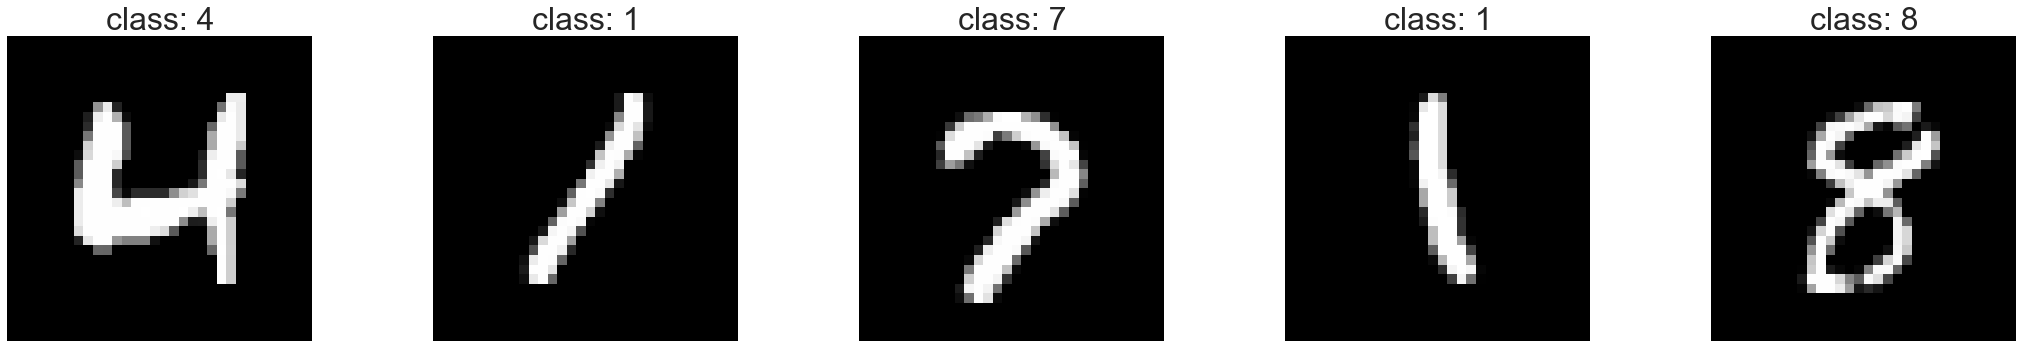

In [6]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_train.shape[0], size=5)

for n, i in enumerate(idx):

    sns.heatmap(data=X_train[i],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
                )

    ax[n].set_title(f'class: {np.argmax(y_train[i]):d}', fontsize=32)

plt.tight_layout()


## Classification Model

In what follows, we train a simple convolutional neural network to classify the digits in the dataset.

The fundamental principle of the convolutions is the scan of the image by a smaller *window*:

<img src="https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="640px">

Image by [Mayank Mishra](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939)

By repeating the same operation on multiple filters, we get a tensor structure with an additional *channel* direction:

<img src="https://raw.githubusercontent.com/dvgodoy/dl-visuals/main/Convolutions/3channel_filters1.png" width="640px">

Image by [dvgodoy](https://github.com/dvgodoy/dl-visuals) / [CC BY](https://creativecommons.org/licenses/by/4.0)

In this implementation we develop a *fully convolutional neural network* (that is, no fully connected layers are used), in order to avoid any dependence on the size of the input image.

In [7]:
K.clear_session()

cnn = Sequential([Conv2D(filters=64,
                         kernel_size=(3, 3),
                         activation='relu',
                         input_shape=(None, None, 1),
                         name='cnn_input'
                         ),
                  MaxPool2D(pool_size=(3, 3), name='cnn_pool_1'),
                  Conv2D(filters=128,
                         kernel_size=(2, 2),
                         activation='relu',
                         name='cnn_hidden_1'
                         ),
                  MaxPool2D(pool_size=(2, 2), name='cnn_pool_2'),
                  Conv2D(filters=64,
                         kernel_size=(2, 2),
                         activation='relu',
                         name='cnn_hidden_2'
                         ),
                  MaxPool2D(pool_size=(2, 2), name='cnn_pool_3'),
                  Conv2D(filters=10,
                         kernel_size=(1, 1),
                         activation='softmax',
                         name='cnn_output'
                         )
                  ],
                 name='fully_convolutional_nn'
                 )

cnn.summary()


Model: "fully_convolutional_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (Conv2D)           (None, None, None, 64)    640       
_________________________________________________________________
cnn_pool_1 (MaxPooling2D)    (None, None, None, 64)    0         
_________________________________________________________________
cnn_hidden_1 (Conv2D)        (None, None, None, 128)   32896     
_________________________________________________________________
cnn_pool_2 (MaxPooling2D)    (None, None, None, 128)   0         
_________________________________________________________________
cnn_hidden_2 (Conv2D)        (None, None, None, 64)    32832     
_________________________________________________________________
cnn_pool_3 (MaxPooling2D)    (None, None, None, 64)    0         
_________________________________________________________________
cnn_output (Conv2D)          (None, None, No

Finally, we train the network using the [Adam](https://arxiv.org/abs/1404.7359) optimiser of stochastic gradient descent.
We use $5 \times 10^4$ images for effective training, and $10^4$ for evaluation (validation) of the model.

In [8]:
cnn.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy()]
            )

if TRAIN_CNN:

    history = cnn.fit(x=X_train[:50000, :, :, None],
                      y=y_train[:50000, None, None, :],
                      batch_size=128,
                      epochs=10,
                      validation_data=(X_train[50000:, :, :, None],
                                       y_train[50000:, None, None, :]
                                       ),
                      callbacks=[ModelCheckpoint('./fully_convolutional_nn.h5',
                                                 save_best_only=True
                                                 )
                                 ]
                      )

cnn.load_weights('./fully_convolutional_nn.h5')


Epoch 1/10
391/391 [==============================] - 6s 10ms/step - loss: 0.4656 - categorical_accuracy: 0.8657 - val_loss: 0.1624 - val_categorical_accuracy: 0.9503
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 0.1444 - categorical_accuracy: 0.9562 - val_loss: 0.1065 - val_categorical_accuracy: 0.9701
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 0.1013 - categorical_accuracy: 0.9691 - val_loss: 0.0880 - val_categorical_accuracy: 0.9752
Epoch 4/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0828 - categorical_accuracy: 0.9744 - val_loss: 0.0813 - val_categorical_accuracy: 0.9772
Epoch 5/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0683 - categorical_accuracy: 0.9786 - val_loss: 0.0719 - val_categorical_accuracy: 0.9792
Epoch 6/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0595 - categorical_accuracy: 0.9812 - val_loss: 0.0639 - val_categorical_accuracy: 0.9806
Epo

For visualisation purposes, we plot the loss function and the accuracy as functions of the training epochs.

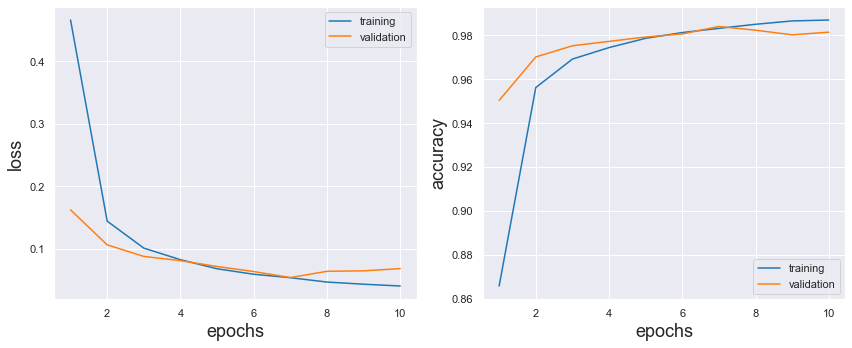

In [9]:
if TRAIN_CNN:

    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.lineplot(x=range(1, 10+1),
                 y=history.history['loss'],
                 ls='-',
                 color='tab:blue',
                 label='training',
                 ax=ax[0]
                 )
    sns.lineplot(x=range(1, 10+1),
                 y=history.history['val_loss'],
                 ls='-',
                 color='tab:orange',
                 label='validation',
                 ax=ax[0]
                 )
    ax[0].set_xlabel('epochs', fontsize=18)
    ax[0].set_ylabel('loss', fontsize=18)

    sns.lineplot(x=range(1, 10+1),
                 y=history.history['categorical_accuracy'],
                 ls='-',
                 color='tab:blue',
                 label='training',
                 ax=ax[1]
                 )
    sns.lineplot(x=range(1, 10+1),
                 y=history.history['val_categorical_accuracy'],
                 ls='-',
                 color='tab:orange',
                 label='validation',
                 ax=ax[1]
                 )
    ax[1].set_xlabel('epochs', fontsize=18)
    ax[1].set_ylabel('accuracy', fontsize=18)

    plt.tight_layout()


Finally, we compute the predictions on the final $10^4$ images in the test set (these realisations were never seen by the algorithm).

In [10]:
y_pred = cnn.predict(X_test[:, :, :, None]).squeeze().argmax(axis=-1)

print(f'Prediction accuracy: {(y_pred == y_test).mean():.2%}')


Prediction accuracy: 98.40%


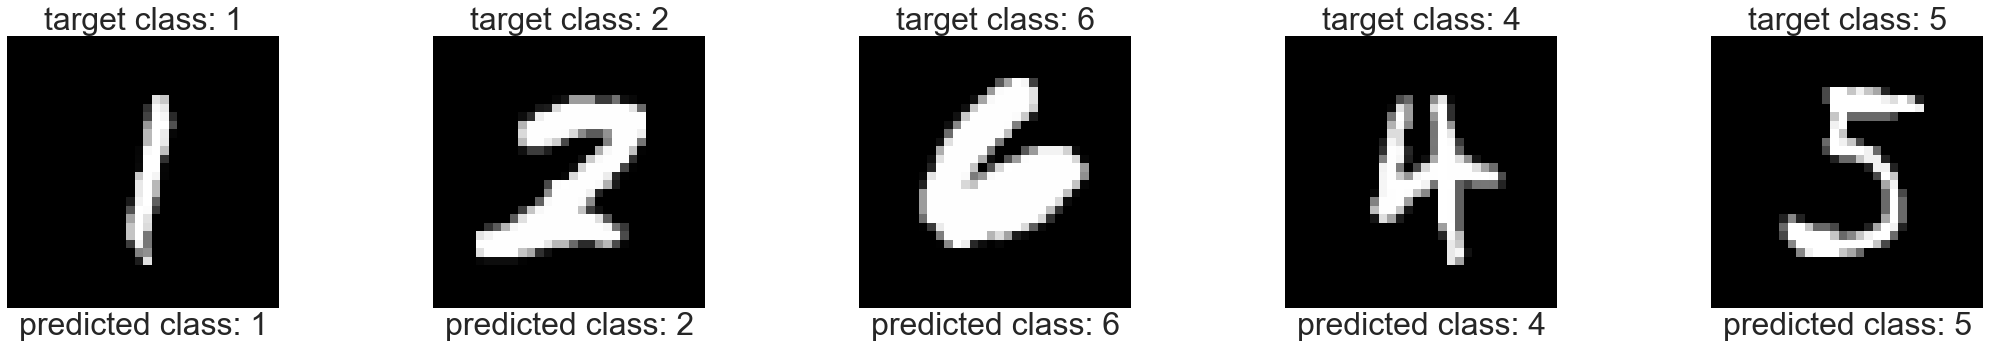

In [11]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test.shape[0], size=5)

for n, i in enumerate(idx):

    sns.heatmap(data=X_test[i],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
                )

    ax[n].set_title(f'target class: {y_test[i]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {y_pred[i]:d}', fontsize=32)

plt.tight_layout()


Given the peculiarity of the network, we can also provide the predictions for inputs of different sizes. For instance:

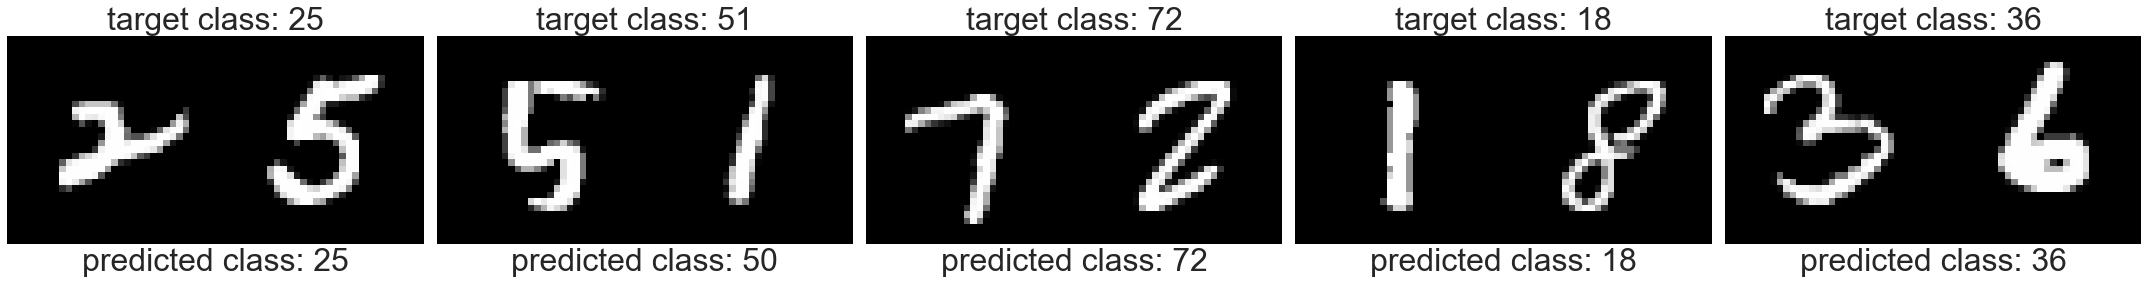

In [12]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test.shape[0], size=10)
for n in range(5):

    conc = np.concatenate([X_test[idx[n]], X_test[idx[9-n]]], axis=1)

    sns.heatmap(data=conc,
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
                )

    pred = cnn.predict(conc[None, :, :, None]).squeeze().argmax(axis=1)
    ax[n].set_title(f'target class: {y_test[idx[n]]:d}{y_test[idx[9-n]]:d}',
                    fontsize=32
                    )
    ax[n].set_xlabel(f'predicted class: {pred[0]:d}{pred[-1]:d}',
                     fontsize=32
                     )

plt.tight_layout()


## Autoencoder as Denoise Filter

In what follows, we introduce a source of defects inside the distribution of the input data. In general, this may prevent the network from performing at the same accuracy levels.

In [13]:
X_train_noise = X_train + 1.75 * np.random.uniform(size=X_train.shape)
X_test_noise = X_test + 1.75 * np.random.uniform(size=X_test.shape)
y_pred_noise = cnn.predict(X_test_noise[:, :, :, None]).squeeze()
y_pred_noise = y_pred_noise.argmax(axis=-1)

print(f'Prediction accuracy: {(y_pred_noise == y_test).mean():.2%}')


Prediction accuracy: 26.19%


The reason for such a drop in accuracy may become clear once we visualise some realisations in the new "noisy" dataset.

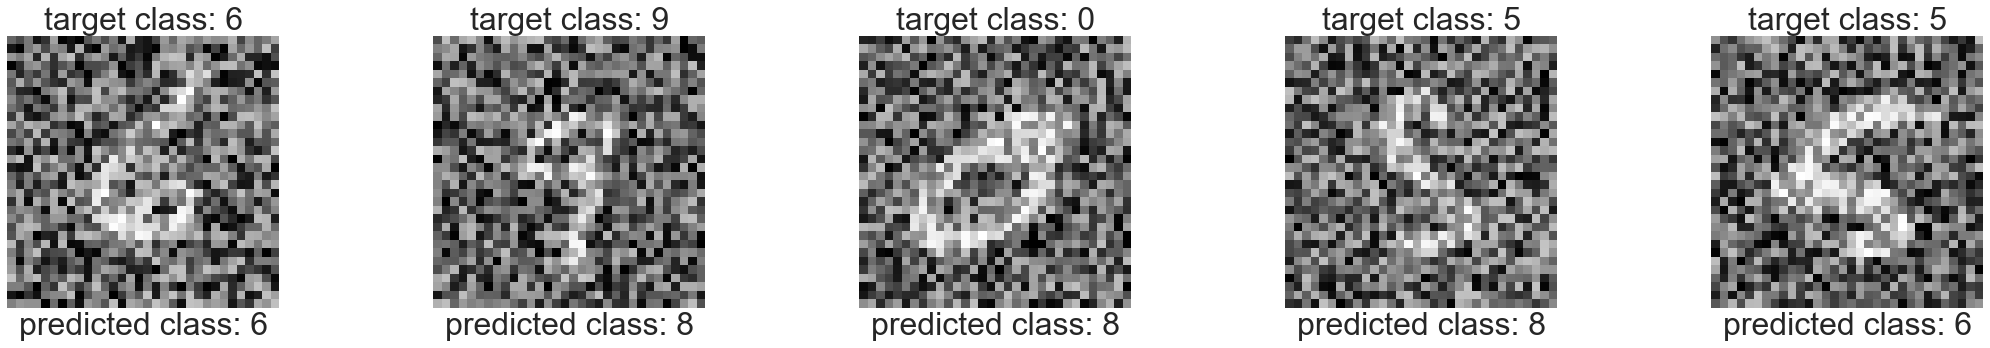

In [14]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test_noise.shape[0], size=5)

for n, i in enumerate(idx):

    sns.heatmap(data=X_test_noise[i],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
                )

    ax[n].set_title(f'target class: {y_test[i]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {y_pred_noise[i]:d}', fontsize=32)

plt.tight_layout()


One way to tackle the problem is to use a particular *unsupervised* approach.
We focus on an **autoencoder** architecture, whose job is to extract only the relevant information contained in the noisy image, and to rebuild a clean pattern:

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" width="640px">

Image by [Lilian Weng](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

Again, we use a fully convolutional model to avoid dependencies on the size of the input image.

In [15]:
K.clear_session()

ae = Sequential([Conv2D(filters=128,
                        kernel_size=(3, 3),
                        activation='tanh',
                        input_shape=(None, None, 1),
                        name='ae_input'
                        ),
                 MaxPool2D(pool_size=(3, 3), name='ae_pool_1'),
                 Conv2D(filters=64,
                        kernel_size=(2, 2),
                        activation='tanh',
                        name='ae_down_1'
                        ),
                 MaxPool2D(pool_size=(2, 2), name='ae_pool_2'),
                 Conv2D(filters=64,
                        kernel_size=(2, 2),
                        activation='tanh',
                        name='ae_down_2'
                        ),
                 UpSampling2D(size=(3, 3), name='ae_upsample_1'),
                 Conv2DTranspose(filters=64,
                                 kernel_size=(2, 2),
                                 activation='relu',
                                 name='ae_up_1'
                                 ),
                 UpSampling2D(size=(3, 3), name='ae_upsample_2'),
                 Conv2DTranspose(filters=128,
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 name='ae_up_2'
                                 ),
                 Conv2D(filters=1,
                        kernel_size=(1, 1),
                        # activation='sigmoid',
                        name='ae_output'
                        ),
                 ],
                name='autoencoder'
                )

ae.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (Conv2D)            (None, None, None, 128)   1280      
_________________________________________________________________
ae_pool_1 (MaxPooling2D)     (None, None, None, 128)   0         
_________________________________________________________________
ae_down_1 (Conv2D)           (None, None, None, 64)    32832     
_________________________________________________________________
ae_pool_2 (MaxPooling2D)     (None, None, None, 64)    0         
_________________________________________________________________
ae_down_2 (Conv2D)           (None, None, None, 64)    16448     
_________________________________________________________________
ae_upsample_1 (UpSampling2D) (None, None, None, 64)    0         
_________________________________________________________________
ae_up_1 (Conv2DTranspose)    (None, None, None, 64)    

In [16]:
ae.compile(optimizer=Adam(learning_rate=1.0e-3),
           loss=MeanSquaredError(),
           metrics=[BinaryAccuracy()]
           )

if TRAIN_AE:

    history = ae.fit(x=X_train_noise[:50000, :, :, None],
                     y=X_train[:50000, :, :, None],
                     batch_size=128,
                     # epochs=5,
                     epochs=50,
                     validation_data=(X_train_noise[50000:, :, :, None],
                                      X_train[50000:, :, :, None]
                                      ),
                     callbacks=[ModelCheckpoint('./autoencoder.h5',
                                                save_best_only=True
                                                )
                                ]
                     )

ae.load_weights('./autoencoder.h5')


Epoch 1/50
391/391 [==============================] - 15s 37ms/step - loss: 0.0443 - binary_accuracy: 0.8442 - val_loss: 0.0378 - val_binary_accuracy: 0.8402
Epoch 2/50
391/391 [==============================] - 13s 34ms/step - loss: 0.0337 - binary_accuracy: 0.8457 - val_loss: 0.0311 - val_binary_accuracy: 0.8480
Epoch 3/50
391/391 [==============================] - 13s 34ms/step - loss: 0.0298 - binary_accuracy: 0.8471 - val_loss: 0.0295 - val_binary_accuracy: 0.8443
Epoch 4/50
391/391 [==============================] - 13s 34ms/step - loss: 0.0280 - binary_accuracy: 0.8477 - val_loss: 0.0272 - val_binary_accuracy: 0.8495
Epoch 5/50
391/391 [==============================] - 14s 35ms/step - loss: 0.0268 - binary_accuracy: 0.8481 - val_loss: 0.0265 - val_binary_accuracy: 0.8489
Epoch 6/50
391/391 [==============================] - 13s 34ms/step - loss: 0.0261 - binary_accuracy: 0.8484 - val_loss: 0.0261 - val_binary_accuracy: 0.8475
Epoch 7/50
391/391 [==============================] 

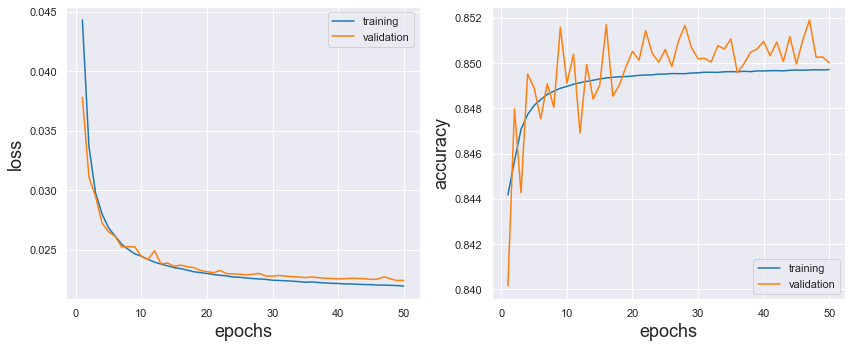

In [18]:
if TRAIN_AE:

    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.lineplot(x=range(1, 50+1),
                 y=history.history['loss'],
                 ls='-',
                 color='tab:blue',
                 label='training',
                 ax=ax[0]
                 )
    sns.lineplot(x=range(1, 50+1),
                 y=history.history['val_loss'],
                 ls='-',
                 color='tab:orange',
                 label='validation',
                 ax=ax[0]
                 )
    ax[0].set_xlabel('epochs', fontsize=18)
    ax[0].set_ylabel('loss', fontsize=18)

    sns.lineplot(x=range(1, 50+1),
                 y=history.history['binary_accuracy'],
                 ls='-',
                 color='tab:blue',
                 label='training',
                 ax=ax[1]
                 )
    sns.lineplot(x=range(1, 50+1),
                 y=history.history['val_binary_accuracy'],
                 ls='-',
                 color='tab:orange',
                 label='validation',
                 ax=ax[1]
                 )
    ax[1].set_xlabel('epochs', fontsize=18)
    ax[1].set_ylabel('accuracy', fontsize=18)

    plt.tight_layout()


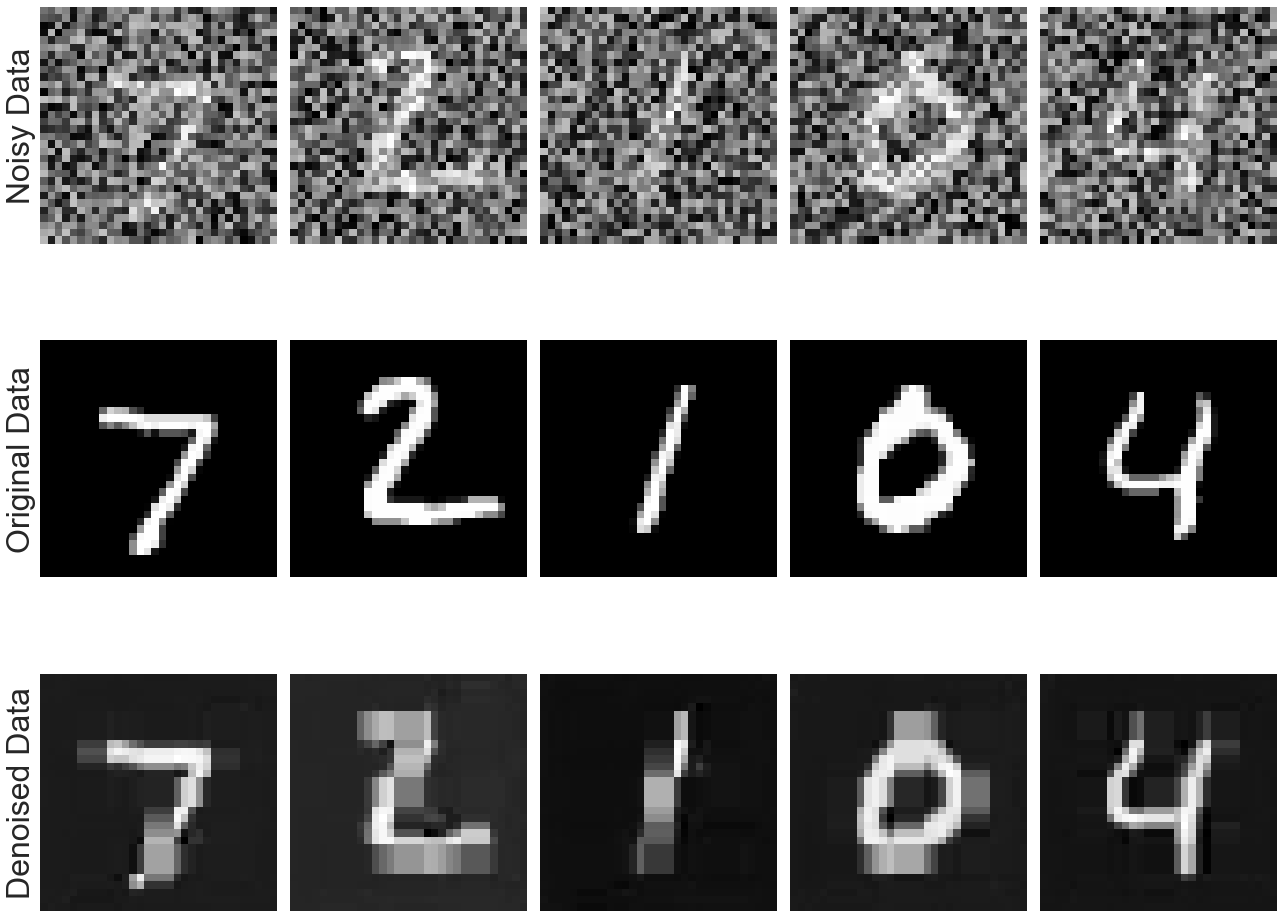

In [19]:
X_preds = ae.predict(X_test_noise[:, :, :, None]).squeeze()

_, ax = plt.subplots(3, 5, figsize=(18, 15), sharey=True, sharex=True)
idx = np.random.choice(X_preds.shape[0], size=5)

for n, i in enumerate(idx):

    sns.heatmap(data=X_test_noise[n],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[0, n]
                )

    sns.heatmap(data=X_test[n],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[1, n]
                )

    sns.heatmap(data=X_preds[n],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[2, n]
                )

ax[0, 0].set_ylabel('Noisy Data', fontsize=32)
ax[1, 0].set_ylabel('Original Data', fontsize=32)
ax[2, 0].set_ylabel('Denoised Data', fontsize=32)

plt.tight_layout()


In [20]:
K.clear_session()

cv = Model(inputs=ae.input, outputs=cnn(ae.output), trainable=False, name='CV')


In [21]:
y_pred = cv.predict(X_test_noise[:, :, :, None]).squeeze().argmax(axis=-1)

print(f'Prediction accuracy: {(y_pred == y_test).mean():.2%}')


Prediction accuracy: 92.22%


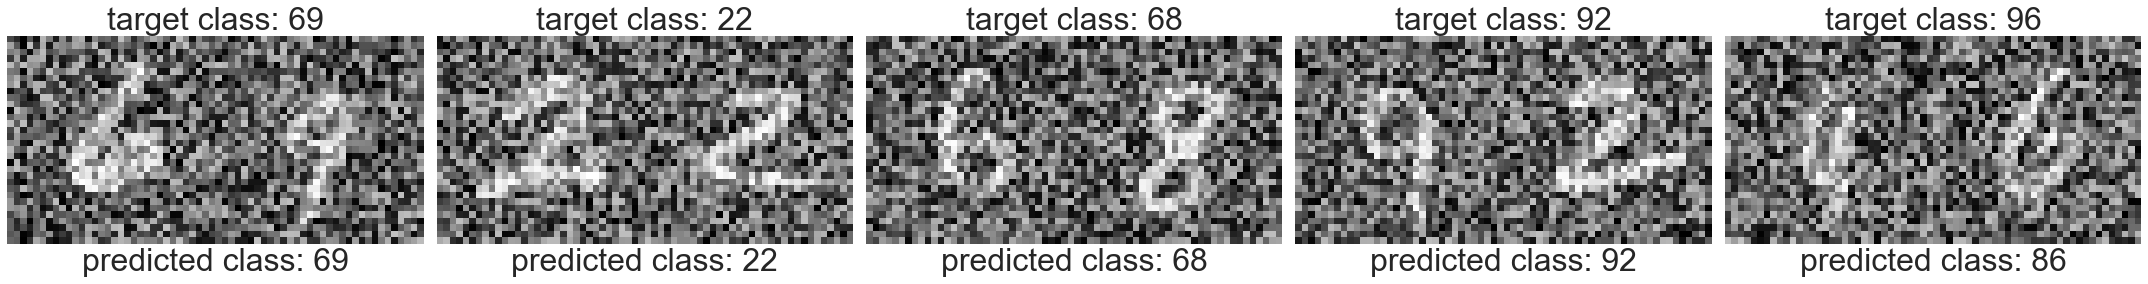

In [22]:
_, ax = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
idx = np.random.choice(X_test.shape[0], size=10)
for n in range(5):

    conc = np.concatenate(
        [X_test_noise[idx[n]], X_test_noise[idx[9-n]]], axis=1)

    sns.heatmap(data=conc, cmap='Greys_r', cbar=False,
                xticklabels=False, yticklabels=False,
                square=True, ax=ax[n]
                )

    pred = cv.predict(conc[None, :, :, None]).squeeze().argmax(axis=1)
    ax[n].set_title(
        f'target class: {y_test[idx[n]]:d}{y_test[idx[9-n]]:d}', fontsize=32)
    ax[n].set_xlabel(f'predicted class: {pred[0]:d}{pred[-1]:d}', fontsize=32)

plt.tight_layout()
